In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

import edward as ed
import numpy as np
import tensorflow as tf

In [14]:
n_cust = 10
n_order = 1000
p_below = 1
p_above = 0

df = pd.DataFrame(index=np.arange(0, n_order))
df['customer'] = np.random.choice(a=n_cust, size=n_order)
df['price'] = np.random.gamma(scale=20, shape=3, size=n_order)
dfc = pd.DataFrame(index=np.arange(0, n_cust))
dfc['customer_up'] = np.random.gamma(scale=10, shape=10, size=n_cust)
df = df.merge(dfc, left_on='customer', right_index=True)
df['above'] = (df['customer_up'] <= df['price']).astype(int)
df['below'] = (df['customer_up'] > df['price']).astype(int)

df['kept'] = (np.random.choice([0, 1], p=[1-p_below, p_below], size=n_order) * df['below'] + 
    np.random.choice([0, 1], p=[1-p_above, p_above], size=n_order) * df['above'])

    

In [15]:
df['kept'].value_counts()

1    853
0    147
Name: kept, dtype: int64

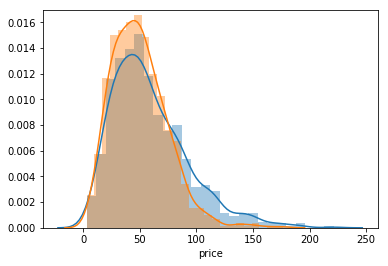

In [16]:
sns.distplot(df['price'])
sns.distplot(df.loc[df['below'] == 1, 'price'])

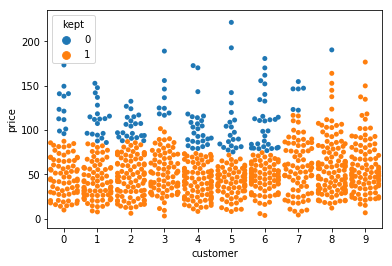

In [17]:
sns.swarmplot(x="customer", y="price", hue="kept", data=df)


In [ ]:
sns.distplot(df['customer_up'])

We build a toy datasets where the target depends linear on the features.

In [121]:
ed.models.Bernoulli?

In [59]:
def beta(pc1=1, pc0=1, D=1):
    prio = ed.models.Beta(concentration1=tf.ones(D)*pc1, concentration0=tf.ones(D)*pc0)
    post = ed.models.Beta(
        concentration1=tf.nn.softplus(tf.Variable(tf.random_normal([D])*pc1)), 
        concentration0=tf.nn.softplus(tf.Variable(tf.random_normal([D])*pc0))
    )
    return prio, post

def gamma(pc=1, pr=1, D=1):
    prio = ed.models.Gamma(concentration=tf.ones(D)*pc, rate=tf.ones(D)*pr)
    post = ed.models.Gamma(
        concentration=tf.nn.softplus(tf.Variable(tf.random_normal([D])*pc)), 
        rate=tf.nn.softplus(tf.Variable(tf.random_normal([D])*pr)))
    return prio, post

In [73]:
customer = tf.placeholder(tf.int64, [n_order])
price = tf.placeholder(tf.float32, [n_order])


switching, switching_w = gamma(pc=1, pr=1, D=1)
upper_limit, upper_limit_w = gamma(pc=10, pr=0.1, D=n_cust)

customer_upper_limit = tf.nn.embedding_lookup(upper_limit, customer)

kept = ed.models.BernoulliWithSigmoidProbs((price - customer_upper_limit)*switching)

In [74]:
latent_vars = {switching: switching_w, upper_limit: upper_limit_w}

In [69]:
inference = ed.KLqp(latent_vars, data={kept: df['kept'].values, price: df['price'].values, customer: df['customer'].values})
inference.run(n_samples=1, n_iter=1)

In [70]:
k_post = ed.copy(kept, latent_vars)
# This is equivalent to
# y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(N))

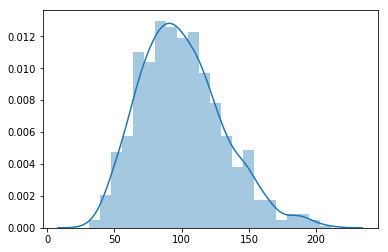

In [71]:
sns.distplot(upper_limit.sample(1000).eval()[:,0])

In [85]:
upper_limit_w.sample(1000).eval()[:,0]

FailedPreconditionError: Attempting to use uninitialized value Variable_27
	 [[Node: Variable_27/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_27"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_27)]]

Caused by op 'Variable_27/read', defined at:
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-73-08fc39a6a9e2>", line 6, in <module>
    upper_limit, upper_limit_w = gamma(pc=10, pr=0.1, D=n_cust)
  File "<ipython-input-59-d6ea6409d71f>", line 13, in gamma
    rate=tf.nn.softplus(tf.Variable(tf.random_normal([D])*pr)))
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 330, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1400, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/lbrinkm/projects/doing_bayesian_da/.venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable_27
	 [[Node: Variable_27/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_27"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_27)]]


In [57]:
sns.distplot(upper_limit_w.sample(1000).eval()[:,0], color=sns.color_palette("hls", 1))


ValueError: Invalid RGBA argument: [(0.85999999999999999, 0.37119999999999997, 0.33999999999999997)]